### Install packages

In [ ]:
!pip install gunpowder
!pip install zarr
!pip install pandas
!pip install pathlib
!pip install networkx

### import packages

In [ ]:
import gunpowder as gp
import os
import glob
import numpy as np
import zarr
import tifffile
import matplotlib.pyplot as plt
import napari
import pandas as pd
import pathlib
from tifffile import imread, imwrite
import matplotlib
import skimage
import networkx

In [1143]:
### Convert data into zarr format
def tif2zarr(baseDir,groupKey,outDir='',chunkSize=48):
    if outDir=='':
        outDir = baseDir+"/zarr/"
    
    # load all tiff files 
    img = np.stack([tifffile.imread(xi) for xi in sorted(glob.glob(baseDir+"/"+"*.tif"))])  # images

    # format: [timepoints,zslices,y,z]
    imDims = img.shape
    
    # define chunk size
    if isinstance(chunkSize, int):
        chunks = np.repeat(chunkSize,len(imDims))
    else:
        chunks = chunkSize
                  
    # write img into zarr file       
    #zFile = zarr.open(outDir, shape=imDims, chunks=chunks, mode="w", dtype='int32')
    store = zarr.DirectoryStore(outDir)
    zFile = zarr.open_group(store=store,mode='w')
        
    zGroup = zFile.create_dataset(groupKey, shape=imDims,chunks=chunks,dtype='int32')
    #zFile = zarr.open_group(outDir+"/"+groupKey,mode='w',shape=imDims, chunks=chunks, dtype='int32')
    zFile[groupKey] = img
        
    return outDir

In [1144]:
dataDir = "/mnt/shared/celltracking/data/cho/01"
zarr_dir = "/mnt/shared/celltracking/data/cho/01.zarr"
zarrdir = tif2zarr(dataDir,'raw',zarr_dir)
print(f'zarr data directory:{zarrdir}')

zarr data directory:/mnt/shared/celltracking/data/cho/01.zarr


In [1145]:
root = zarr.open(zarrdir)
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,1
No. arrays,1
No. groups,0
Arrays,raw


### Import hardcoded volume pairs with gunpowder

batch returned: 
	raw: ROI: [0:1, 0:5, 65:165, 160:260] (1, 5, 100, 100), voxel size: (1, 1, 1, 1), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False

4


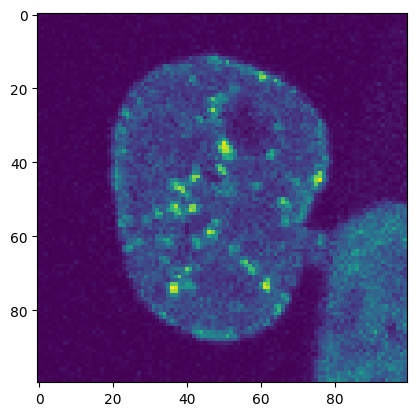

In [1149]:
# declare arrays to use in the pipeline
key ='raw'

coord_paired = ((0,0,65, 160),(1,0,67, 165))
coord_unpaired = ((0,0,65, 160),(1,0,60, 200))

# specify subvolume size and volume source
volSize = (1,5,100, 100)
coord = coord_paired[0]

raw_shift = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: key},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(interpolatable=True)}  # meta-information
)+ gp.Pad(raw_shift, None) + gp.Pad(raw, None)
pipeline = source

# specify request
request = gp.BatchRequest()
request[raw_shift] = gp.Roi(coord, volSize)


# build the pipeline...
with gp.build(pipeline):

  # ...and request a batch
  batch = pipeline.request_batch(request)
  
# show the content of the batch
print(f"batch returned: {batch}")

# plot first slice of volume
plt.imshow(np.flipud(batch[raw_shift].data[0,0,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");

### Extract cell centroids

In [1165]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data
base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")


# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

# extract centroids from annotated image stacks
centers = skimage.measure.regionprops(centroids[0,0,:,:])
tracks = []
for t, frame in enumerate(centroids):
    centers = skimage.measure.regionprops(frame)
    for c in centers:
        tracks.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        
# constructs graph 
tracks = np.array(tracks)
graph = networkx.DiGraph()
for cell_id, t, x, y in tracks:
    graph.add_node((cell_id,t), x=x, y=y, t=t)
    
for cell_id, t in graph.nodes():
    if (cell_id, t+1) in graph.nodes():
        graph.add_edge((cell_id, t), (cell_id,t+1))

for child_id, child_from, _, child_parent_id in links:
    for parent_id, _, parent_to, _ in links:
        if child_parent_id == parent_id:
            graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# extract trajectories from graph set
tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# remove tracks with 0 edges
tracks = [track for track in tracks if len(track.edges)>0]

16


### Define updated gunpowder node for providing volume pairs

In [ ]:
### final data format
# Provide one list of paired and separate list of unpaired batches
# batch[raw].data # vol1
# batch[raw_shift].data # vol2

paired = False
sampler(tracks,graph,paired)

### Define new gp.process function for our needs

In [1281]:
class getPaired(gp.BatchFilter):

    def __init__(self, raw, raw_shift, tracks, paired=True):
        self.raw = raw
        self.raw_shift = raw_shift
        self.tracks = tracks
        self.paired = paired
    
    # _ref channel array is stored in raw_ref, while second volume in pair will be stored raw_new
    def prepare(self, request):
        # obtain volume coordinates from tracks                
        deps = gp.BatchRequest()
        vol1,vol2 = self.sampler(request)
                
        deps[self.raw] = gp.ArraySpec(roi=gp.Roi(vol1,request[self.raw].roi.get_shape()))
        deps[self.raw_shift] = gp.ArraySpec(roi=gp.Roi(vol2,request[self.raw_shift].roi.get_shape()))

        return deps
    
    # required to inform downstream nodes about new array 
    def process(self, batch, request):
        # create a new batch to hold the new array
        out_batch = gp.Batch()

        # create new array and store it in the batch
        out_batch[self.raw_shift] = batch[self.raw_shift]
        out_batch[self.raw] = batch[self.raw]
        
        #print(f'raw: {batch[self.raw].spec.roi}')
        #print(batch[self.raw_shift].spec.roi)
        
        # make sure that coordinates for batch[raw] and batch[raw_shift] are reset to (0,0,0,0,0)
        out_batch[self.raw].spec.roi = request[self.raw].roi
        out_batch[self.raw_shift].spec.roi = request[self.raw_shift].roi

        # return the new batch
        return out_batch
    
    # select pairs of subvolumes from data
    def sampler(self,request):
        tracks = self.tracks
        paired = self.paired
        # choose connected nodes
        # if self.paired:
        if paired:
            t0 = tracks[np.random.randint(0,len(tracks),1).item()]
            e0 = list(t0.edges)[np.random.randint(len(list(t0.edges)))]
            node0 = t0.nodes[e0[0]]
            node1 = t0.nodes[e0[1]]
            
        # choose random unconnected nodes
        else:
            # randomly choose two tracks and make sure they are not identical
            t0,t1 = np.random.randint(0,len(tracks),2)
            while t0==t1:
                t0,t1 = np.random.randint(0,len(tracks),2)

            #print(f'trackids: {t0,t1}')
            t0 = tracks[t0]
            t1 = tracks[t1]

            # choose random edges from each track
            #print(f'number edges per track{len(list(t0.nodes)),len(list(t1.nodes))}')

            r0 = np.random.randint(0,len(list(t0.nodes))) 
            r1 = np.random.randint(0,len(list(t1.nodes)))

            node0 = t0.nodes[list(t0.nodes)[r0]]
            node1 = t1.nodes[list(t1.nodes)[r1]]
            


        node0_xyt = [node0["x"], node0["y"], node0["t"]]
        node1_xyt = [node1["x"], node1["y"], node1["t"]]

        #print(f'input coord: {node0_xyt,node1_xyt}')

        roi_in = request[self.raw_shift].roi.get_shape()
        #t,z,y,x
        coords_vol0 = (node0_xyt[2],0,node0_xyt[0]-(roi_in[2]/2),node0_xyt[1]-(roi_in[3]/2))
        coords_vol1 = (node1_xyt[2],0,node1_xyt[0]-(roi_in[2]/2),node1_xyt[1]-(roi_in[3]/2))
        #print(f'output coords - vol0: {coords_vol0}, vol1:{coords_vol1}')

        return coords_vol0, coords_vol1
            

### Test automated volume sampling pipeline

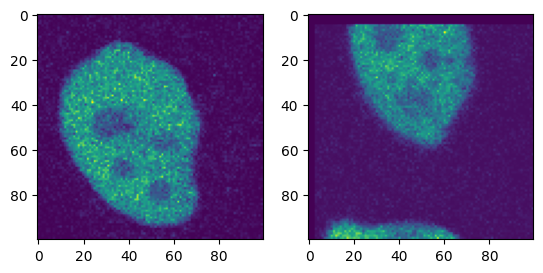

In [1284]:
# specify subvolume size and volume source
volSize = (1,5,100, 100)
coord = (0,0,0,0)

raw = gp.ArrayKey('raw')
raw_shift = gp.ArrayKey('raw_shift')

# create "pipeline" consisting only of a data source
source = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    )+ 
    gp.Pad(raw_shift, None) + 
    gp.Pad(raw, None))

pipeline = source + getPaired(raw,raw_shift,tracks,paired=False)
    

# specify request
request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)
request[raw_shift] = gp.Roi(coord, volSize)

gp.ArraySpec()
# build the pipeline...
with gp.build(pipeline):

  # ...and request a batch
  batch = pipeline.request_batch(request)
  
# show the content of the batch
#print(f"batch returned: {batch}")

# plot first slice of volume
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.flipud(batch[raw].data[0,0,:,:]))
axs[1].imshow(np.flipud(batch[raw_shift].data[0,0,:,:]))

# load volume into napari
# viewer = napari.Viewer()
# viewer.add_image(batch[raw].data, name="volume 1");